In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from ipywidgets import interact, widgets


2024-10-14 14:52:04.531448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 14:52:04.647557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 14:52:04.752689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:52:04.878831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:52:04.912742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:52:05.018355: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Step 1: Load the dataset
file_path = r"/home/jupyter-yasai/wing_downforce_con.csv"  # Update this path
df = pd.read_csv(file_path)

# Step 2: Drop constant columns (like Speed, Cd_downforce, Cd_drag) if they exist in your new data
df = df.drop(columns=['Speed (m/s)', 'Cd_downforce', 'Cd_drag'])  # Adjust these column names as per your dataset

# Step 3: Split data into 70% training and 30% temporary (test + validation)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=22)

# Step 4: Split the temporary data into 20% test and 10% validation
test_data, validation_data = train_test_split(temp_data, test_size=1/3, random_state=42)

# Step 5: Separate the features (X) and target (y)
X_train = train_data.drop(columns=["Downforce (N)"])  # Features
y_train = train_data["Downforce (N)"]  # Target

X_test = test_data.drop(columns=["Downforce (N)"])
y_test = test_data["Downforce (N)"]

X_val = validation_data.drop(columns=["Downforce (N)"])
y_val = validation_data["Downforce (N)"]

# Step 6: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


Epoch 1/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 9144.3691 - mae: 61.9271 - val_loss: 4060.5737 - val_mae: 42.9702
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8302.3779 - mae: 57.6906 - val_loss: 4042.9546 - val_mae: 42.7182
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8771.4453 - mae: 58.8786 - val_loss: 4016.2290 - val_mae: 42.3503
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10560.7578 - mae: 64.8142 - val_loss: 3978.5090 - val_mae: 41.8335
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8258.2695 - mae: 57.6334 - val_loss: 3927.5703 - val_mae: 41.2300
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9226.9033 - mae: 61.0710 - val_loss: 3861.0774 - val_mae: 40.4988
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9629.3086 - mae: 62.6917 - val_loss: 3778.5259 - val_mae: 39.5595
Epoch 8/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9191.7637 - mae: 61.2285 - val_loss: 3676.9492 - val_mae: 38.3598
Epoch 

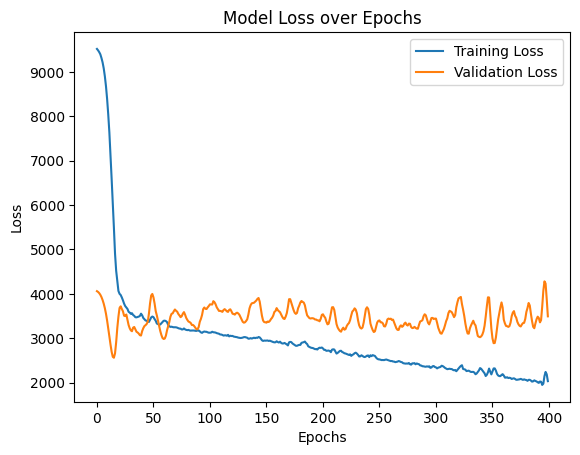

interactive(children=(FloatSlider(value=1.6621596183512364, description='Width (m)', max=2.967217341501293, mi…

<function __main__.interactive_mesh_grid(width, length, wing_angle)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/steptep

In [3]:

# Step 7: Define the Keras model with an explicit Input layer
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(512, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)  # Output layer for regression (predicting downforce)
])

# Step 8: Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 9: Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=400,
    batch_size=32,
    verbose=1
)

# Step 10: Plot the training and validation loss (static graph)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


# Step 11: Interactive 3D mesh grid visualization with predicted downforce
def interactive_mesh_grid(width, length, wing_angle):
    # Define the range of values for Width (m) and Wing Angle (degrees)
    width_range = np.linspace(X_train['Width (m)'].min(), X_train['Width (m)'].max(), 100)
    angle_range = np.linspace(X_train['Wing Angle (degrees)'].min(), X_train['Wing Angle (degrees)'].max(), 100)
    width_grid, angle_grid = np.meshgrid(width_range, angle_range)

    # Flatten the grid and prepare the input for the model
    flat_width = width_grid.flatten()
    flat_angle = angle_grid.flatten()

    # Use the length provided by the slider
    length_constant = length

    # Prepare the input features for prediction
    grid_input = pd.DataFrame({
        'Width (m)': flat_width,
        'Length (m)': np.full_like(flat_width, length_constant),
        'Wing Angle (degrees)': flat_angle
    })

    # Scale the input features
    grid_input_scaled = scaler.transform(grid_input)

    # Predict the downforce for each point in the grid
    downforce_pred = model.predict(grid_input_scaled)

    # Reshape the predictions back to the shape of the mesh grid
    downforce_grid = downforce_pred.reshape(width_grid.shape)

    # Step 12: Plot the mesh grid
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(width_grid, angle_grid, downforce_grid, cmap='viridis')

    # Set labels
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Wing Angle (degrees)')
    ax.set_zlabel('Predicted Downforce (N)')

    plt.title(f'Predicted Downforce for Length = {length:.2f} m')
    plt.show()

    # Step 13: Predict downforce for the selected sliders' values
    input_data = pd.DataFrame({
        'Width (m)': [width],
        'Length (m)': [length],
        'Wing Angle (degrees)': [wing_angle]
    })

    # Scale the input data
    input_data_scaled = scaler.transform(input_data)

    # Predict the downforce
    predicted_downforce = model.predict(input_data_scaled)
    
    # Print the predicted downforce
    print(f"\nPredicted Downforce for Width = {width:.2f} m, Length = {length:.2f} m, Wing Angle = {wing_angle:.2f}°: {predicted_downforce[0][0]:.2f} N")

# Step 14: Create interactive sliders for all three parameters
width_slider = widgets.FloatSlider(min=X_train['Width (m)'].min(), max=X_train['Width (m)'].max(), step=0.01, value=X_train['Width (m)'].mean(), description='Width (m)')
length_slider = widgets.FloatSlider(min=X_train['Length (m)'].min(), max=X_train['Length (m)'].max(), step=0.01, value=X_train['Length (m)'].mean(), description='Length (m)')
angle_slider = widgets.FloatSlider(min=X_train['Wing Angle (degrees)'].min(), max=X_train['Wing Angle (degrees)'].max(), step=0.1, value=X_train['Wing Angle (degrees)'].mean(), description='Wing Angle (°)')

# Step 15: Use the interact function to create an interactive mesh grid visualization
interact(interactive_mesh_grid, width=width_slider, length=length_slider, wing_angle=angle_slider)
